# Deep Learning Handson session 4

We will learn:
1. How to create a CNN block.
2. Save the trained model.
3. Freeze layers

In [1]:
# All the necessary imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters for the model
num_epochs = 5
batch_size = 4
learning_rate = 0.001

In [4]:
# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
# obtain training indices that will be used for validation
valid_size=0.2
num_train = len(train_dataset)
print(f"Length of train data {num_train}")
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]
print(len(train_index))
print(len(valid_index))

Length of train data 50000
40000
10000


In [6]:
# define samplers for obtaining training and validation batches
from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

In [7]:
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Target
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

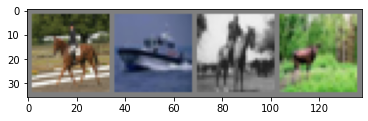

In [9]:
# display the images of the dataset
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# CNN Architecture
[conv->activation function->pooling layers]
followed by classifier layers.
1. conv(in_channel =3, out_channel =6,kernel_size =5)
2. conv(in_channel =6, out_channel =16,kernel_size =5)
3. Three fully connected layers of dimension fc1=120,fc2=84,fc3=10.
4. relu activation is used

In [10]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5) # 3X32X32
        self.conv2 = nn.Conv2d(6,16,5)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self, x):
        x = F.relu(self.conv1(x))   # (32 -5) +1 = # 6X28X28
        x = self.pool(x)    # (28 -2)/2 +1 = # 6X14X14
        x = F.relu(self.conv2(x))   # (14 -5) +1 = # 16X10X10
        x = self.pool(x)# (10 -2)/2 +1 = # 16X5x5
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
# sending the model to gpu
model = ConvNet().to(device)
print(model)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [12]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
# training loop
best_loss = np.inf
train_loss = []
val_loss = []
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    final_loss = 0
    valid_loss = 0
    model.train()
    print("Train executing-------->")
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

        final_loss +=loss.item()
        
    train_loss.append(final_loss/len(train_loader))
    model.eval()
    print("Validation executing-------->")
    for i, (images, labels) in enumerate(valid_loader):
        with torch.no_grad():
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            if (i+1) % 500 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(valid_loader)}], Loss: {loss.item():.4f}')
            valid_loss +=loss.item()
    valid_loss = valid_loss/len(valid_loader)
    val_loss.append(valid_loss)
    if(best_loss>valid_loss):
        print(f"At Epoch {epoch+1} Current best loss {best_loss}, current val loss {valid_loss} updating the best loss and saving the model")
        best_loss = valid_loss
        PATH = './cnn.pth'
        torch.save(model.state_dict(), PATH)

print('Finished Training')

Train executing-------->
Epoch [1/5], Step [2000/10000], Loss: 2.2530
Epoch [1/5], Step [4000/10000], Loss: 2.3202
Epoch [1/5], Step [6000/10000], Loss: 2.3163
Epoch [1/5], Step [8000/10000], Loss: 2.3003
Epoch [1/5], Step [10000/10000], Loss: 2.2995
Validation executing-------->
Epoch [1/5], Step [500/2500], Loss: 2.3205
Epoch [1/5], Step [1000/2500], Loss: 2.2952
Epoch [1/5], Step [1500/2500], Loss: 2.2808
Epoch [1/5], Step [2000/2500], Loss: 2.3184
Epoch [1/5], Step [2500/2500], Loss: 2.2853
At Epoch 1 Current best loss inf, current val loss 2.298610443019867 updating the best loss and saving the model
Train executing-------->
Epoch [2/5], Step [2000/10000], Loss: 2.2807
Epoch [2/5], Step [4000/10000], Loss: 2.2605
Epoch [2/5], Step [6000/10000], Loss: 2.2319
Epoch [2/5], Step [8000/10000], Loss: 2.7575
Epoch [2/5], Step [10000/10000], Loss: 2.1494
Validation executing-------->
Epoch [2/5], Step [500/2500], Loss: 2.0370
Epoch [2/5], Step [1000/2500], Loss: 2.2024
Epoch [2/5], Step [

In [14]:
print(len(train_loss))
print(len(val_loss))

5
5


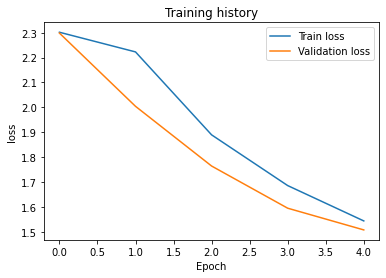

In [15]:
import matplotlib.pyplot as plt
plot1 = plt.figure(1)
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()

In [16]:
#Load the Model with Lowest Validation Loss
best_model = ConvNet().to(device)
best_model.load_state_dict(torch.load(PATH))

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')


Accuracy of the network: 45.48 %
Accuracy of plane: 41.4 %
Accuracy of car: 61.7 %
Accuracy of bird: 19.1 %
Accuracy of cat: 29.0 %
Accuracy of deer: 23.9 %
Accuracy of dog: 43.3 %
Accuracy of frog: 73.4 %
Accuracy of horse: 61.5 %
Accuracy of ship: 48.7 %
Accuracy of truck: 52.8 %


In [17]:
print(model)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [18]:
counter = 0
print(f"Total trainable parameters initially:{sum(p.numel() for p in model.parameters())}")
for child in model.children():
    counter +=1
    print(f"Layer: {counter}, child: {child}")
    if counter == 1:
        for param in child.parameters():
            param.requires_grad = False
            
print(f"Total trainable parameters after freezing layer 1:{sum(p.numel() for p in model.parameters() if p.requires_grad)}") # this includes bias
print(f"Total non-trainable parameters layer 1:{sum(p.numel() for p in model.parameters() if p.requires_grad==False)}")

# In Layer 1 total parameters = kernel_size*#kernels + bias = 5*5*3*6 + 6 = 456 are set to false, bias = #kernels

# Setting all to True
counter = 0
for child in model.children():
    counter+=1
    #print(f"Layer: {counter}, child: {child}")
    for param in child.parameters():
        param.requires_grad = True
print(f"Total trainable parameters initially:{sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# freezing only weights of the first layer not the bias
counter = 0
for child in model.children():
    counter+=1
    #print(f"Layer: {counter}, child: {child}")
    if counter == 1:
        for name, param in child.named_parameters():
            if name == 'weight':
                param.requires_grad = False
            
print(f"Total trainable parameters after freezing weights of Layer 1:{sum(p.numel() for p in model.parameters() if p.requires_grad)}")
print(f"Total non-trainable parameters layer 1:{sum(p.numel() for p in model.parameters() if p.requires_grad==False)}")
# In Layer 1 total parameters = 5*5*3*6 = 450 (bias not included)


Total trainable parameters initially:62006
Layer: 1, child: Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
Layer: 2, child: Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
Layer: 3, child: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer: 4, child: Linear(in_features=400, out_features=120, bias=True)
Layer: 5, child: Linear(in_features=120, out_features=84, bias=True)
Layer: 6, child: Linear(in_features=84, out_features=10, bias=True)
Total trainable parameters after freezing layer 1:61550
Total non-trainable parameters layer 1:456
Total trainable parameters initially:62006
Total trainable parameters after freezing weights of Layer 1:61556
Total non-trainable parameters layer 1:450


In [19]:
# change in optimizer
# By default optimizer is written as optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# But this will give error as this will try to update all the parameters, but we have set a bunch of them to frozen so we pass
# only trainable parameters
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)